In [141]:
"""
ADJ: adjective
ADP: adposition
ADV: adverb
AUX: auxiliary
CCONJ: coordinating conjunction
DET: determiner
INTJ: interjection
NOUN: noun
NUM: numeral
PART: particle
PRON: pronoun
PROPN: proper noun
PUNCT: punctuation
SCONJ: subordinating conjunction
SYM: symbol
VERB: verb
X: other
"""

'\nADJ: adjective\nADP: adposition\nADV: adverb\nAUX: auxiliary\nCCONJ: coordinating conjunction\nDET: determiner\nINTJ: interjection\nNOUN: noun\nNUM: numeral\nPART: particle\nPRON: pronoun\nPROPN: proper noun\nPUNCT: punctuation\nSCONJ: subordinating conjunction\nSYM: symbol\nVERB: verb\nX: other\n'

In [142]:
!pip3 install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
import nltk
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
nltk.download('universal_tagset')
nltk.download('treebank')
sentences = nltk.corpus.treebank.tagged_sents(tagset='universal')
print("Number of Tagged Sentences ",len(sentences))
print(sentences[0])
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Number of Tagged Sentences  3914
[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


In [144]:


word_to_idx = {'UNK':0}
tag_to_idx = {}
char_to_idx = {'UNK':0}


def prepare_words(seq,to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix.keys():
            idxs.append(to_ix['UNK'])
        else:
            idxs.append(to_ix[w])
    return torch.tensor(idxs, dtype=torch.long,device=device)

        

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long,device=device)
def prepare_chars(sentence, to_ix):
    indexes = []
    for word in sentence:
        idxs = []
        for char in word:
            if char not in to_ix.keys():
                idxs.append(to_ix['UNK'])
            else:
                idxs.append(to_ix[char])
        indexes.append(idxs)
    max_length = max(len(row) for row in indexes)
    padded =   [row + [0] * (max_length - len(row))  for row in indexes]
    return torch.tensor(padded, dtype=torch.long,device=device)


for sentence in sentences:
    for word, tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if tag not in tag_to_idx.keys():
            tag_to_idx[tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

print(len(word_to_idx),len(tag_to_idx),len(char_to_idx))

12409 12 80


In [145]:
print(tag_to_idx)
idx_to_tag = {}
confusion_matrix_labels = []
for key, index in tag_to_idx.items():
    idx_to_tag[index] = key
    confusion_matrix_labels.append(key)
print(idx_to_tag)


{'NOUN': 0, '.': 1, 'NUM': 2, 'ADJ': 3, 'VERB': 4, 'DET': 5, 'ADP': 6, 'CONJ': 7, 'X': 8, 'ADV': 9, 'PRT': 10, 'PRON': 11}
{0: 'NOUN', 1: '.', 2: 'NUM', 3: 'ADJ', 4: 'VERB', 5: 'DET', 6: 'ADP', 7: 'CONJ', 8: 'X', 9: 'ADV', 10: 'PRT', 11: 'PRON'}


In [146]:
class Features():
    def fill(self, word_to_idx, tag_to_idx, char_to_idx):
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        self.char_to_idx = char_to_idx
        
        self.idx_to_tag = {}
        for key,index in self.tag_to_idx.items():
            self.idx_to_tag[index] = key
        
    def save(self):
        """save class as self.name.txt"""
        file = open('features.txt','wb')
        file.write(pickle.dumps(self.__dict__))
        file.close()

    def load(self):
        """try load self.name.txt"""
        file = open('features.txt','rb')
        dataPickle = file.read()
        file.close()

features = Features()
features.fill(word_to_idx, tag_to_idx, char_to_idx)
# features.save()

print(features)


In [147]:
data = []
for sentence in sentences:
    words = []
    tags = []
    for word, tag in sentence:
        words.append(word) 
        tags.append(tag)
    data.append((words,tags))

train_len = math.floor(len(data)*0.8)
val_len = math.floor(len(data)*0.1)
test_len = math.floor(len(data)*0.1)

train = data[:train_len]
validation = data[train_len:train_len+val_len]
test = data[train_len+val_len:]
print(len(train),len(validation),len(test))

3131 391 392


In [148]:
# class LSTMTagger(nn.Module):

#     def __init__(self, embedding_dim, char_embedding_dim, hidden_dim, char_hidden_dim, vocab_size, char_vocab_size, tagset_size):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

#         # The LSTM takes word embeddings as inputs, and outputs hidden states
#         # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

#         self.lstm_output_dropout = torch.nn.Dropout(1 - KEEP_DROPOUT)

#         # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        

#     def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
#         lstm_out_dropped = self.lstm_output_dropout(lstm_out)
#         tag_space = self.hidden2tag(lstm_out_dropped.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores


In [149]:
class char_LSTM(nn.Module):
    '''El Chapo'''
    def __init__(self, char_embedding_dim, char_hidden_dim, charset_size):
        super(char_LSTM, self).__init__()
        
        self.char_hidden_dim = char_hidden_dim
        self.char_embedding = nn.Embedding(charset_size, char_embedding_dim)
        self.lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
        self.char_hidden = self.init_hidden()
        
    def init_hidden(self):
        ''' Intialize the hidden state'''
        return (torch.rand(1,1,self.char_hidden_dim, device=device),
               torch.rand(1,1,self.char_hidden_dim, device=device))
    
    def forward(self,single_word):
        ''' Return the final hidden state a.k.a char embedding(This encodes dense character features )'''
        char_embeds = self.char_embedding(single_word)
        self.char_hidden = self.init_hidden()
        _, self.char_hidden = self.lstm(char_embeds.view(len(single_word),1,-1),self.char_hidden)
        return self.char_hidden[0]

class LSTMTagger(nn.Module):
    '''GodFather'''
    def __init__(self, embedding_dim, char_embedding_dim, hidden_dim, char_hidden_dim, vocab_size, char_size, tagset_size,word_num_layers):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.char_LSTM_embedding = char_LSTM(char_embedding_dim, char_hidden_dim, char_size)
        # note : LSTM input size is embedding_dim+char_hidden_dim to play nicely with concatenation
        self.lstm = nn.LSTM(embedding_dim+char_hidden_dim, hidden_dim,num_layers = word_num_layers)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.word_num_layers = word_num_layers
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        ''' Intialize the hidden state'''
        return (torch.rand(self.word_num_layers,1,self.hidden_dim, device=device),
               torch.randn(self.word_num_layers,1,self.hidden_dim, device=device))
    
    def concat_embeddings(self,some_word_embedding_tensor, some_character_embedding_tensor):
        ''' Concatenate the word embedding and character embedding into a single tensor. Do this for all words'''
        combo = []
        for w,c in zip(some_word_embedding_tensor,some_character_embedding_tensor):
            combo.append(torch.cat((w,c)))
        return torch.stack(combo)
    
    def forward(self, sentence, sentence_chars):
        word_embeds = self.word_embeddings(sentence)
        char_embeds = []
        for single_word_char in sentence_chars:
            # iterate through each word and append the character embedding to char_embeds
            char_embeds.append(torch.squeeze(self.char_LSTM_embedding(single_word_char)))
        # Concatenate the word embedding with the char embedding( i.e the hidden state from the char_LSTM for each word)
        word_char_embeds = self.concat_embeddings(word_embeds, char_embeds)
        lstm_out, self.hidden = self.lstm(word_char_embeds.view(len(sentence), 1, -1), (self.hidden[0].detach(), self.hidden[1].detach()))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence),-1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [150]:
WORD_EMBEDDING_DIM = 300
CHAR_EMBEDDING_DIM = 64
WORD_HIDDEN_DIM = 512
CHAR_HIDDEN_DIM = 54
KEEP_DROPOUT = 0.8
word_num_layers = 3
char_num_layers = 2


In [151]:
model = LSTMTagger(WORD_EMBEDDING_DIM, CHAR_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_HIDDEN_DIM,
                   len(word_to_idx), len(char_to_idx), len(tag_to_idx),word_num_layers)

model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

import tqdm
def trainer(model, loss_function, optimizer, train):
    total_loss = 0
    predictions = []
    trues = []

    for sentence, tags in tqdm.tqdm(train):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_words(sentence, word_to_idx)
        char_sequence = prepare_chars(sentence, char_to_idx)
        
        targets = prepare_sequence(tags, tag_to_idx)
        sentence_in.to(device)
        char_sequence.to(device)
        targets.to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in, char_sequence)
        # print(tag_scores.size())
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        # tag_scores = torch.squeeze(tag_scores,0)
        # print(tag_scores.size())

        loss = loss_function(tag_scores, targets)
        total_loss += loss.item()

        _, indices = torch.max(tag_scores, 1)

        predictions = predictions + indices.tolist()
        trues = trues + targets.tolist()

        loss.backward()
        optimizer.step()
    return total_loss, predictions, trues
    

def tester(model, loss_function, test):
    total_loss = 0
    predictions = []
    trues = []

    for sentence, tags in tqdm.tqdm(test):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_words(sentence, word_to_idx)
        char_sequence = prepare_chars(sentence, char_to_idx)
        targets = prepare_sequence(tags, tag_to_idx)
        sentence_in.to(device)
        char_sequence.to(device)
        targets.to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in,char_sequence)

        # tag_scores = torch.squeeze(tag_scores,0)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        
        loss = loss_function(tag_scores, targets)
        total_loss += loss.item()

        
        

        # Caluclating the accuracy of tags
        _, indices = torch.max(tag_scores, 1)

        predictions = predictions + indices.tolist()
        trues = trues + targets.tolist()
    
    return total_loss, predictions, trues
    
    


In [152]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
from sklearn.metrics import f1_score, accuracy_score
import tqdm
TOTAL_EPOCHS = 25
train_losses = []
validation_losses = []
accuracies_t = []
accuracies_v = []
f1s_t = []
f1s_v = []
for epoch in range(TOTAL_EPOCHS):
    train_loss, pred_t, true_t = trainer(model, loss_function, optimizer,train)
    val_loss, pred_v, true_v = tester(model, loss_function, validation)
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VALIDATION LOSS: {val_loss}")
    accuracy_v = accuracy_score(true_v, pred_v)
    accuracy_t = accuracy_score(true_t, pred_t)
    f1_v = f1_score(true_v, pred_v, average='weighted')
    f1_t = f1_score(true_t, pred_t, average='weighted')
    
    print(f"TRAIN ACC: {accuracy_t}")
    print(f"VAL ACC: {accuracy_v}")

    print(f"TRAIN F-1: {f1_t}")
    print(f"VAL F-1: {f1_v}")

    f1s_t.append(f1_t)
    f1s_v.append(f1_v)
    accuracies_t.append(accuracy_t)
    accuracies_v.append(accuracy_v)
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

100%|██████████| 391/391 [00:03<00:00, 109.99it/s]


EPOCH: 0
TRAIN LOSS: 6941.40807390213
VALIDATION LOSS: 855.8461534976959
TRAIN ACC: 0.2838647271103836
VAL ACC: 0.28480516937536715
TRAIN F-1: 0.12717834163586123
VAL F-1: 0.12626659113204955


100%|██████████| 391/391 [00:03<00:00, 121.08it/s]


EPOCH: 1
TRAIN LOSS: 6831.228059887886
VALIDATION LOSS: 853.5106292963028
TRAIN ACC: 0.28491883378597915
VAL ACC: 0.28480516937536715
TRAIN F-1: 0.12635621754686469
VAL F-1: 0.12626659113204955


100%|██████████| 391/391 [00:03<00:00, 121.18it/s]


EPOCH: 2
TRAIN LOSS: 6799.058224916458
VALIDATION LOSS: 846.4365462064743
TRAIN ACC: 0.28491883378597915
VAL ACC: 0.28480516937536715
TRAIN F-1: 0.12635621754686469
VAL F-1: 0.12626659113204955


100%|██████████| 391/391 [00:03<00:00, 120.93it/s]


EPOCH: 3
TRAIN LOSS: 6670.871302485466
VALIDATION LOSS: 818.4668635129929
TRAIN ACC: 0.2967124272976425
VAL ACC: 0.30830233013510866
TRAIN F-1: 0.15825547033963128
VAL F-1: 0.17450777953141527


100%|██████████| 391/391 [00:03<00:00, 120.45it/s]


EPOCH: 4
TRAIN LOSS: 6103.321874201298
VALIDATION LOSS: 707.261824786663
TRAIN ACC: 0.3689993427334846
VAL ACC: 0.3958292539651459
TRAIN F-1: 0.2428336612385628
VAL F-1: 0.27168865907972545


100%|██████████| 391/391 [00:03<00:00, 121.54it/s]


EPOCH: 5
TRAIN LOSS: 5095.07926428318
VALIDATION LOSS: 562.9060210585594
TRAIN ACC: 0.4708012450860027
VAL ACC: 0.5607009986293323
TRAIN F-1: 0.38143168631594454
VAL F-1: 0.4818688580798173


100%|██████████| 391/391 [00:03<00:00, 119.77it/s]


EPOCH: 6
TRAIN LOSS: 4064.2076372504234
VALIDATION LOSS: 441.25127053260803
TRAIN ACC: 0.6054292694420675
VAL ACC: 0.6498923046798512
TRAIN F-1: 0.5367071556958166
VAL F-1: 0.5748011687008122


100%|██████████| 391/391 [00:03<00:00, 119.45it/s]


EPOCH: 7
TRAIN LOSS: 3256.7535484805703
VALIDATION LOSS: 345.6864815726876
TRAIN ACC: 0.6812877463199276
VAL ACC: 0.7351674172704131
TRAIN F-1: 0.6252514303982375
VAL F-1: 0.6885382601775497


100%|██████████| 391/391 [00:03<00:00, 116.51it/s]


EPOCH: 8
TRAIN LOSS: 2566.4342160709202
VALIDATION LOSS: 271.78091513365507
TRAIN ACC: 0.7498418839986607
VAL ACC: 0.7946935578617583
TRAIN F-1: 0.7086504745343105
VAL F-1: 0.7626043143312066


100%|██████████| 391/391 [00:03<00:00, 108.24it/s]


EPOCH: 9
TRAIN LOSS: 2024.522920684889
VALIDATION LOSS: 213.77660893648863
TRAIN ACC: 0.7982067785259869
VAL ACC: 0.8309183473663599
TRAIN F-1: 0.7640555243102
VAL F-1: 0.8100191789369425


100%|██████████| 391/391 [00:03<00:00, 114.70it/s]


EPOCH: 10
TRAIN LOSS: 1516.9511331748217
VALIDATION LOSS: 149.27994367852807
TRAIN ACC: 0.8477249897689646
VAL ACC: 0.885549246132759
TRAIN F-1: 0.8272106382650817
VAL F-1: 0.8739493211840846


100%|██████████| 391/391 [00:03<00:00, 119.24it/s]


EPOCH: 11
TRAIN LOSS: 1113.4051380166784
VALIDATION LOSS: 117.61887481436133
TRAIN ACC: 0.8911913885685231
VAL ACC: 0.9124730761699628
TRAIN F-1: 0.8829424156364
VAL F-1: 0.9093341234948834


100%|██████████| 391/391 [00:03<00:00, 121.86it/s]


EPOCH: 12
TRAIN LOSS: 852.0424970248714
VALIDATION LOSS: 102.2007342018187
TRAIN ACC: 0.9178664880885946
VAL ACC: 0.9234384178578422
TRAIN F-1: 0.914265142037002
VAL F-1: 0.9224321082054029


100%|██████████| 391/391 [00:03<00:00, 121.09it/s]


EPOCH: 13
TRAIN LOSS: 662.8997033117339
VALIDATION LOSS: 93.93625661544502
TRAIN ACC: 0.9366543894242098
VAL ACC: 0.9303896612492657
TRAIN F-1: 0.9348983007443126
VAL F-1: 0.9298592843102965


100%|██████████| 391/391 [00:03<00:00, 119.21it/s]


EPOCH: 14
TRAIN LOSS: 525.5209984985413
VALIDATION LOSS: 90.31948454957455
TRAIN ACC: 0.9497377134566019
VAL ACC: 0.9329351869982377
TRAIN F-1: 0.9487154796172954
VAL F-1: 0.9324041132232503


100%|██████████| 391/391 [00:03<00:00, 121.16it/s]


EPOCH: 15
TRAIN LOSS: 418.2735136107658
VALIDATION LOSS: 88.8241769457236
TRAIN ACC: 0.9603407864875926
VAL ACC: 0.936459761112199
TRAIN F-1: 0.959801399702448
VAL F-1: 0.9356274510540294


100%|██████████| 391/391 [00:03<00:00, 120.16it/s]


EPOCH: 16
TRAIN LOSS: 334.25447815295774
VALIDATION LOSS: 91.09261050343048
TRAIN ACC: 0.9686248248322731
VAL ACC: 0.9378304288231839
TRAIN F-1: 0.9682977473453451
VAL F-1: 0.936952587391199


100%|██████████| 391/391 [00:03<00:00, 120.53it/s]


EPOCH: 17
TRAIN LOSS: 270.3999626233126
VALIDATION LOSS: 91.55731269950047
TRAIN ACC: 0.9754083113211057
VAL ACC: 0.9408654787546504
TRAIN F-1: 0.9752148883636158
VAL F-1: 0.9406439021550167


100%|██████████| 391/391 [00:03<00:00, 119.93it/s]


EPOCH: 18
TRAIN LOSS: 217.12413261434995
VALIDATION LOSS: 96.42716569534969
TRAIN ACC: 0.9811128886243288
VAL ACC: 0.9392010965341688
TRAIN F-1: 0.9809940479308341
VAL F-1: 0.9396269168404273


100%|██████████| 391/391 [00:03<00:00, 120.44it/s]


EPOCH: 19
TRAIN LOSS: 177.81663393764757
VALIDATION LOSS: 102.46638487686869
TRAIN ACC: 0.9849200739114798
VAL ACC: 0.9378304288231839
TRAIN F-1: 0.984849223846086
VAL F-1: 0.9388980473470626


100%|██████████| 391/391 [00:03<00:00, 121.06it/s]


EPOCH: 20
TRAIN LOSS: 149.68578196168528
VALIDATION LOSS: 109.96866089582909
TRAIN ACC: 0.9877475600530774
VAL ACC: 0.9346974740552183
TRAIN F-1: 0.9877010711178704
VAL F-1: 0.9362930940973828


100%|██████████| 391/391 [00:03<00:00, 121.56it/s]


EPOCH: 21
TRAIN LOSS: 125.20750976073032
VALIDATION LOSS: 115.26352091570152
TRAIN ACC: 0.9897813658742265
VAL ACC: 0.936459761112199
TRAIN F-1: 0.9897501180241036
VAL F-1: 0.9380277850915693


100%|██████████| 391/391 [00:03<00:00, 119.66it/s]


EPOCH: 22
TRAIN LOSS: 104.92222121068335
VALIDATION LOSS: 138.407558185987
TRAIN ACC: 0.9918275729503826
VAL ACC: 0.9267671822988056
TRAIN F-1: 0.9918043461575449
VAL F-1: 0.9265773527849048


100%|██████████| 391/391 [00:03<00:00, 111.34it/s]


EPOCH: 23
TRAIN LOSS: 89.42184528164216
VALIDATION LOSS: 122.89463888492901
TRAIN ACC: 0.9931545072361323
VAL ACC: 0.9353828079107108
TRAIN F-1: 0.9931380497867867
VAL F-1: 0.9375086407704188


100%|██████████| 391/391 [00:03<00:00, 120.41it/s]


EPOCH: 24
TRAIN LOSS: 76.23248565718313
VALIDATION LOSS: 124.92632896103896
TRAIN ACC: 0.9939729900665948
VAL ACC: 0.9394948110436656
TRAIN F-1: 0.9939652014086711
VAL F-1: 0.9398068709228151


In [153]:
test_loss, pred, true = tester(model, loss_function, test)
print(f"VALIDATION LOSS: {test_loss}")
print(f"VAL F-1: {f1_score(true, pred, average='weighted')}")
print(f"VAL ACC: {accuracy_score(true, pred)}")

100%|██████████| 392/392 [00:03<00:00, 123.45it/s]

VALIDATION LOSS: 121.98847255423607
VAL F-1: 0.9351803259647357
VAL ACC: 0.9349618320610688


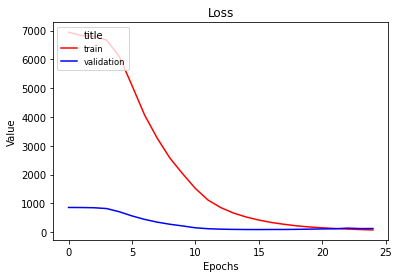

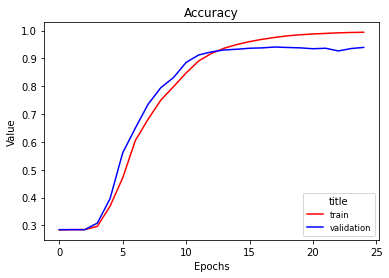

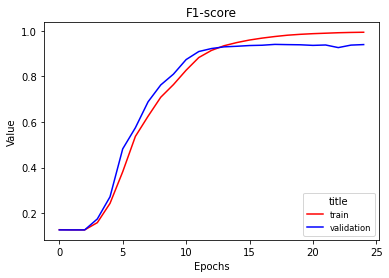

In [154]:
import matplotlib.pyplot as plt
plt.title('Loss')
t, = plt.plot(train_losses, c="red", label ="train")
v, = plt.plot(validation_losses, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(handles=[t,v],loc='upper left', title="title", fontsize='small', fancybox=True)
plt.show()


plt.title('Accuracy')
t, = plt.plot(accuracies_t, c="red", label ="train")
v, = plt.plot(accuracies_v, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(handles=[t,v], title="title",loc=4, fontsize='small', fancybox=True)

plt.show()

plt.title('F1-score')
t, = plt.plot(f1s_t, c="red", label ="train")
v, = plt.plot(f1s_v, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(handles=[t,v], title="title",loc=4, fontsize='small', fancybox=True)


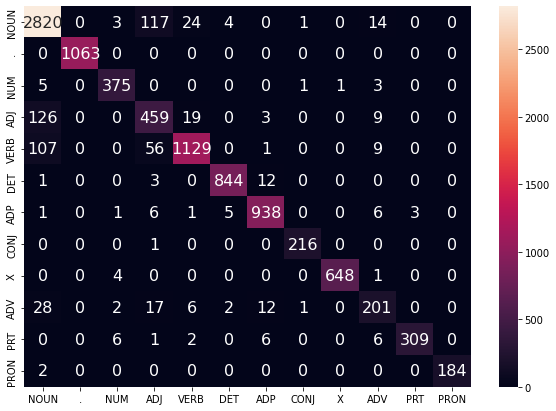

In [155]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


df_cm = pd.DataFrame(confusion_matrix(true, pred), index=confusion_matrix_labels, columns= confusion_matrix_labels)
plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='g', annot_kws={"size": 16}) # font size

plt.show()

In [156]:
torch.save(model.state_dict(), './model_file')

In [157]:
import pickle
def prepare_words(seq,to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix.keys():
            idxs.append(to_ix['UNK'])
        else:
            idxs.append(to_ix[w])
    return torch.tensor(idxs, dtype=torch.long,device=device)


class Features():
    def fill(self, word_to_idx, tag_to_idx, char_to_idx):
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        self.char_to_idx = char_to_idx
        
        self.idx_to_tag = {}
        for key,index in self.tag_to_idx.items():
            self.idx_to_tag[index] = key
        
    def save(self):
        """save class as self.name.txt"""
        file = open('features.txt','wb')
        file.write(pickle.dumps(self.__dict__))
        file.close()

    def load(self):
        """try load self.name.txt"""
        file = open('features.txt','rb')
        dataPickle = file.read()
        file.close()
        self.__dict__ = pickle.loads(dataPickle)
features = Features()
features.load()


FileNotFoundError: ignored

In [ ]:
import nltk
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = 'cpu'

WORD_EMBEDDING_DIM = 300
CHAR_EMBEDDING_DIM = 100
WORD_HIDDEN_DIM = 512
CHAR_HIDDEN_DIM = 128
KEEP_DROPOUT = 0.8


class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, char_embedding_dim, hidden_dim, char_hidden_dim, vocab_size, char_vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        self.lstm_output_dropout = torch.nn.Dropout(1 - KEEP_DROPOUT)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out_dropped = self.lstm_output_dropout(lstm_out)
        tag_space = self.hidden2tag(lstm_out_dropped.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [ ]:



model = LSTMTagger(WORD_EMBEDDING_DIM, CHAR_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_HIDDEN_DIM,
                   len(features.word_to_idx), len(features.char_to_idx), len(features.tag_to_idx))
model.load_state_dict(torch.load('./model_file'))
model.to(device)


In [ ]:
def predict(model, query):
    query = nltk.word_tokenize(query)
    model.zero_grad()

    sentence_in = prepare_words(query, features.word_to_idx)
    
    tag_scores = model(sentence_in)

    _, indices = torch.max(tag_scores, 1)

    indices = indices.tolist()

    preds = [features.idx_to_tag[x] for x in indices]
    print(preds)
    print(query)
    
predict(model,'When did Messi win the champions league?')